In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="data/naver_shopping_tot.txt")

('data/naver_shopping_tot.txt', <http.client.HTTPMessage at 0x7ffd0ec74f70>)

In [4]:
total_data = pd.read_table('data/naver_shopping_tot.txt', names=['ratings', 'reviews'])
total_data.shape

(200000, 2)

In [5]:
total_data.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [6]:
total_data['ratings'].value_counts()

5    81177
2    63989
1    36048
4    18786
Name: ratings, dtype: int64

In [7]:
total_data['label'] = np.select([total_data['ratings']>3],[1], default=0)
total_data.head()

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [9]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [10]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
total_data.shape

(199908, 3)

In [12]:
total_data.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [13]:
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=42)
print(train_data.shape)
print(test_data.shape)

(149931, 3)
(49977, 3)


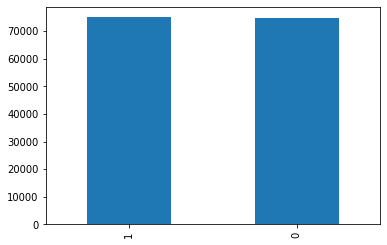

In [14]:
train_data['label'].value_counts().plot(kind='bar')

In [15]:
train_data['label'].value_counts()

1    75013
0    74918
Name: label, dtype: int64

In [19]:
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,74918
1,1,75013


In [20]:
# 데이터 정제
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data['reviews'].replace("", np.nan, inplace=True)
train_data.isnull().sum()

<ipython-input-20-8fb57b417255>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
/Users/kebhana/opt/anaconda3/envs/py-nlp/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


ratings    0
reviews    0
label      0
dtype: int64

In [21]:
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace("", np.nan, inplace=True)
test_data.isnull().sum()

<ipython-input-21-dfc2d21ba80f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/Users/kebhana/opt/anaconda3/envs/py-nlp/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


ratings    0
reviews    0
label      0
dtype: int64

In [22]:
print(train_data.shape)
print(test_data.shape)

(149931, 3)
(49977, 3)


In [25]:
mecab = Mecab()
print(mecab.morphs("morphs 테스트를 한번 해봅니다."))

['morphs', '테스트', '를', '한번', '해', '봅니다', '.']


In [26]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [28]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])

<ipython-input-28-653fc4473298>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
<ipython-input-28-653fc4473298>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])


In [29]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])

<ipython-input-29-96b26c2cb70f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
<ipython-input-29-96b26c2cb70f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['tokenized'] = test_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])


In [30]:
train_data.head()

,ratings,reviews,label,tokenized
59666,2,사이즈를 센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이...,0,"[사이즈, 센치, 씩, 늘린, 건데, 작, 아요, 그리고, 색상, 완전, 달라요, ..."
12433,2,ㅂ불만족 빗이 아픔 멍이피부에 빗질못해주겟네요,0,"[ㅂ, 불, 만족, 빗이, 아픔, 멍, 피부, 빗, 질, 못해, 주, 겟, 네요]"
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요 혹시나해서 다시 빼보니 물이 다시 잘...,0,"[제품, 쓰, 삼, 일, 만, 변기, 물, 잘, 안, 내려갔, 어요, 혹시나, 해서..."
158109,5,적당하고 만족합니다,1,"[적당, 만족, 합니다]"
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0,"[편하, 자고, 이용, 밀키, 튼, 데, 손, 은근, 많이, 서, 저, 패, 쓰, 요]"


In [31]:
test_data.head()

,ratings,reviews,label,tokenized
193242,1,너무 낮고 솜도 적고 실망스럽습니다,0,"[너무, 낮, 솜, 적, 실망, 스럽, 습니다]"
125080,1,피부에 뾰루지가 많이 올라와요,0,"[피부, 뾰루지, 많이, 올라, 와요]"
122750,5,배송도 빠르네요 가격대비 좋은것 같아요 첨에는 힘들어하나 조금 지나니 잘 하네요,1,"[배송, 빠르, 네요, 가격, 대비, 좋, 것, 같, 아요, 첨, 힘들, 어, 하나..."
72927,5,재구매입니다 핏도 좋고 착용감도 좋습니다,1,"[재, 구매, 입니다, 핏, 좋, 착용감, 좋, 습니다]"
83890,1,파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요,0,"[파손, 제품, 온, 거, 출장, 같, 오늘, 받, 았, 는데, 현재, 상황, 장난..."


In [32]:
negative_words = np.hstack(train_data.loc[train_data['label']==0]['tokenized'].values)
positive_words = np.hstack(train_data.loc[train_data['label']==1]['tokenized'].values)


In [33]:
negative_words_count = Counter(negative_words)
print(negative_words_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [34]:
positive_words_count = Counter(positive_words)
print(positive_words_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이: 13.5877381253916
부정 리뷰의 평균 길이: 17.029498918817907


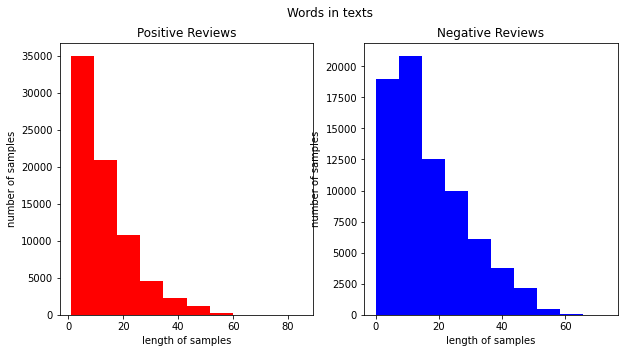

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
text_len = train_data.loc[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이:', np.mean(text_len))

text_len =train_data.loc[train_data['label'] == 0 ]['tokenized'].map(lambda x:len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이:', np.mean(text_len))
plt.show()

In [36]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [39]:
threshold = 2 
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935259575621343


In [41]:
vocab_size = total_cnt - rare_cnt +2
print('단어 집합의 크기:', vocab_size)

단어 집합의 크기: 21787


In [42]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [44]:
X_train[:2]

[[67,
  2060,
  299,
  14260,
  263,
  73,
  6,
  236,
  168,
  137,
  805,
  2951,
  625,
  2,
  77,
  62,
  207,
  40,
  1343,
  155,
  3,
  6],
 [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2]]

In [45]:
X_test[:3]

[[14, 704, 767, 116, 186, 252, 12],
 [339, 3904, 62, 3816, 1651],
 [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]

리뷰의 평균 길이: 15.307528129606286
리뷰의 최대 길이: 85


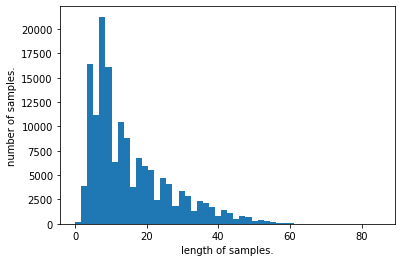

In [47]:
print('리뷰의 평균 길이:', sum(map(len, X_train)) / len(X_train))
print('리뷰의 최대 길이:', max(len(l) for l in X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples.')
plt.ylabel('number of samples.')
plt.show()

In [49]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s) < max_len):
            cnt = cnt+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [50]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [51]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [52]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [54]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('model/naver_shopping_review.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [55]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2694 - acc: 0.8980
Epoch 00001: val_acc improved from -inf to 0.91833, saving model to model/naver_shopping_review.h5
2000/2000 [==============================] - 123s 62ms/step - loss: 0.2694 - acc: 0.8980 - val_loss: 0.2286 - val_acc: 0.9183
Epoch 2/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2150 - acc: 0.9226
Epoch 00002: val_acc improved from 0.91833 to 0.92247, saving model to model/naver_shopping_review.h5
2000/2000 [==============================] - 132s 66ms/step - loss: 0.2150 - acc: 0.9226 - val_loss: 0.2161 - val_acc: 0.9225
Epoch 3/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9292
Epoch 00003: val_acc improved from 0.92247 to 0.92547, saving model to model/naver_shopping_review.h5
2000/2000 [==============================] - 130s 65ms/step - loss: 0.1983 - acc: 0.9292 - val_loss: 0.2037 - val_acc: 0.9255
Epoch 4/15
1999/2000 [==================

In [58]:
loaded_model = load_model('model/naver_shopping_review.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


1562/1562 [==============================] - 13s 8ms/step - loss: 0.2102 - acc: 0.9253

 테스트 정확도: 0.9253


In [59]:
def sentiment_predict(new_sentence):
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen=max_len)
    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰 입니다.".format(score *100))
    else:
        print("{:.2f}% 확률로 부정 리뷰 입니다.".format((1-score)*100))

In [60]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

99.24% 확률로 긍정 리뷰 입니다.


In [61]:
sentiment_predict('이 상품 별로인듯.. 개구림')

99.67% 확률로 부정 리뷰 입니다.
